<a href="https://colab.research.google.com/github/falva12/10-days-of-statistics/blob/master/%5BGermany%201st%20iteration%5D%20Testing_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
import pandas as pd
import random
import math
import string

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

random.seed(123)  # Set the random seed to a specific value

Authenticated


#1. Data for DE

## Products

In [179]:
%%bigquery products --project flink-data-dev
select 
*
from `flink-data-dev.dbt_falvarez.shelf_opt_items`

where clean_storage_type is not null
-- no measures for 11014789 or 103200540
and sku not in ('11014789', '103200540')


Query is running:   0%|          |

Downloading:   0%|          |

In [180]:
products.placement_group.unique()

array(['Fruits & Vegetables', 'Valuables', 'Drinks', 'Main', 'Fragile',
       'Paper', 'Bakery'], dtype=object)

In [181]:
placementDict = { "Drinks": 0, "Main": 1, "Bakery": 2,
                  "Fruits & Vegetables": 3, "Fragile": 4, "Paper": 5, "Valuables": 6}  

products["placement_group_id"] = products["placement_group"].replace(placementDict)               

In [182]:
products.head()

,sku,item_name,placement_group,item_category,item_subcategory,item_brand_name,is_food,is_organic,safety_stock,units_per_handling_unit,...,is_hu_storage,item_handling_unit_length,item_handling_unit_height,item_handling_unit_width,item_length,item_width,item_height,item_weight,item_handling_unit_weight,placement_group_id
0,99000186,Minze,Fruits & Vegetables,Herbs,Mint,None,Food,False,1,6,...,True,240,200,105,270,85,10,15,90,3
1,99000160,Bio Mais gekocht,Fruits & Vegetables,Vegetables,Corns,None,Food,True,1,16,...,True,400,162,300,<NA>,<NA>,<NA>,200,3200,3
2,99000040,Bio Kiwi gepackt,Fruits & Vegetables,Fruits,Kiwis,None,Food,True,1,6,...,True,400,110,300,<NA>,<NA>,<NA>,<NA>,0,3
3,99000222,Limetten gepackt,Fruits & Vegetables,Fruits,Limes,None,Food,False,1,12,...,True,400,162,300,<NA>,<NA>,<NA>,<NA>,0,3
4,99000072,Birnen Abate,Fruits & Vegetables,Fruits,Pears,None,Food,False,1,35,...,True,600,152,400,<NA>,<NA>,<NA>,<NA>,0,3


## Sales

In [183]:
%%bigquery sales --project flink-data-dev
select 
*
from `flink-data-dev.dbt_falvarez.shelf_opt_sales_l28d` 
where country_iso = 'DE'


Query is running:   0%|          |

Downloading:   0%|          |

In [184]:
sales.head()

,country_iso,hub_size,parent_sku,sku,avg_daily_item_quantity,avg_daily_orders
0,DE,S,11018467,11018467,0.211277,317.815217
1,DE,S,11016924,11016924,0.161992,317.815217
2,DE,S,11013136,11013136,2.694973,317.815217
3,DE,S,11019355,11019355,5.654891,317.815217
4,DE,S,11012811,11012811,3.845722,317.815217


## hardware

In [185]:
hardware = {
    "Dry": {
        "height": 2100,
        "width": 1000,
        "depth": 600,
        "shelfs_per_width": 1,
        "weight": 1500000,
        "shelf_height_a": 100,
        "shelf_height_b": 150,
        "shelf_height_c": 200,
        "shelf_height_d": 250,
        "shelf_height_e": 300,
        "shelf_height_f": 350,
        "shelf_height_g": 400,
        "shelf_height_h": 450,
        "shelf_height_i": 500,
        "shelf_height_j": 550,
    },
    "Fridge": {
        "height": 1300,
        "width": 1000,
        "depth": 450,
        "shelfs_per_width": 2,
        "weight": 15000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Ice-Bot": {
        "height": 440,
        "width": 2280,
        "depth": 660,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Ice-Top": {
        "height": 750,
        "width": 2400,
        "depth": 400,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Freezer": {
        "height": 750,
        "width": 2400,
        "depth": 400,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },
    "Meat Top": {
        "height": 750,
        "width": 2400,
        "depth": 400,
        "shelfs_per_width": 4,
        "weight": 150000,
        "shelf_height_a": 150,
        "shelf_height_b": 180,
        "shelf_height_c": 210,
        "shelf_height_d": 320,
        "shelf_height_e": 350,
        "shelf_height_f": 380,
        "shelf_height_g": 420
    },    
}


# hardware = pd.DataFrame.from_dict(hardware_data, orient='index')

# hardware.reset_index(level=0, inplace=True)
# hardware.columns = ['type', 'height', 'width', 'depth', 'shelfs_per_width', 'weight',
#                     'shelf_height_a', 'shelf_height_b', 'shelf_height_c', 'shelf_height_d',
#                     'shelf_height_e', 'shelf_height_f', 'shelf_height_g', 'shelf_height_h', 'shelf_height_i', 'shelf_height_j']

# # hardware['min_shelfs'] = hardware['height'] // hardware['shelf_height_l']
# # hardware['max_shelfs'] = hardware['height'] // hardware['shelf_height_s']

# hardware.head()

##hub hardware

In [186]:
hubHardwareDict = {}

for country in ['DE', 'FR', 'NL']:
  hubHardwareDict[country] = {}

  for size in ['XS', 'S', 'M', 'L', 'XL']:
    hubHardwareDict[country][size] = {}

    for storage_type in ["Dry", "Fridge", "Ice-Bot", "Ice-Top", "Freezer", "Meat Top"]:
      hubHardwareDict[country][size][storage_type] = random.randrange(1, 21) * 5

# hub_hardware = pd.DataFrame(hubHardwareDict)
# hub_hardware.reset_index(0, inplace= True)
# hub_hardware.columns = ['hub_size', 'DE', 'FR', 'NL']

# hub_hardware.head()

In [187]:
hubHardwareDict['DE']['M'] = {'Dry': [8, 8, 13, 8, 8],
                           'Fridge': [5, 4, 4, 5],
                           'Ice-Bot': [2, 1, 1],
                           'Ice-Top': [2, 1, 2],
                           'Freezer': [4, 2, 3],
                           'Meat Top': [1]}
hubHardwareDict['DE']['M']

{'Dry': [8, 8, 13, 8, 8],
 'Fridge': [5, 4, 4, 5],
 'Ice-Bot': [2, 1, 1],
 'Ice-Top': [2, 1, 2],
 'Freezer': [4, 2, 3],
 'Meat Top': [1]}

## Review Data

In [188]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sku                        2341 non-null   object 
 1   item_name                  2341 non-null   object 
 2   placement_group            2341 non-null   object 
 3   item_category              2341 non-null   object 
 4   item_subcategory           2341 non-null   object 
 5   item_brand_name            2271 non-null   object 
 6   is_food                    2341 non-null   object 
 7   is_organic                 2341 non-null   boolean
 8   safety_stock               2341 non-null   Int64  
 9   units_per_handling_unit    2341 non-null   Int64  
 10  item_storage_types         2341 non-null   object 
 11  clean_storage_type         2341 non-null   object 
 12  is_hu_storage              2341 non-null   boolean
 13  item_handling_unit_length  2187 non-null   Int64

In [189]:
products.columns

Index(['sku', 'item_name', 'placement_group', 'item_category',
       'item_subcategory', 'item_brand_name', 'is_food', 'is_organic',
       'safety_stock', 'units_per_handling_unit', 'item_storage_types',
       'clean_storage_type', 'is_hu_storage', 'item_handling_unit_length',
       'item_handling_unit_height', 'item_handling_unit_width', 'item_length',
       'item_width', 'item_height', 'item_weight', 'item_handling_unit_weight',
       'placement_group_id'],
      dtype='object')

In [190]:
products['sku'].nunique()

2341

In [191]:
# products[products['sku'].isin(df['sku'].unique())].groupby(products['item_handling_unit_height'])['sku'].count()

In [192]:
# products[products['sku'].isin(df['sku'].unique())]['item_handling_unit_height'].map(int).plot.bar()

# 2. Facings

1. Calculate multipliers (`multiplierSales`, `multiplierFrequency` and `multiplierStorage`)
2. Calculate `rowCapacity` as the max items for one facing
3. Calculate `expectedStock` as (avg_daily_sales + SS)* `multiplierFrequency` or purchase_units in case there is no daily_sales. We can also include waste here
4. Calculate `rowFacings` as `expectedStock`/ `rowCapacity`
5. Calculate final `facings` as round of `rowFacings`
6. Calculate `neededWidth`, `maxStock` and `expectedWeight`

## Functions

In [216]:
#@title Function to check if a product should be storaged as HU
def checkIfIsHUStorage(product):
  '''returns true when is_hu_storage is true and there is a
  valid value for item_handling_unit_width'''
  return(True if product['is_hu_storage'] and isinstance(product['item_handling_unit_width'], (int, float))
  else False)

In [217]:
#@title Function to calculate levelCapacity depending on is_hu_storage
def calculateLevelFacingCapacity(product, storageWidth):
  '''Function to calculate the amount of facings
     that can be placed in a single shelf level
  '''
  if checkIfIsHUStorage(product):
    levelCapacity = (
      1
      if product['item_handling_unit_width'] >= storageWidth
      else (
          storageWidth // product['item_handling_unit_width']
      )
    )
  else:
        levelCapacity = (
      1
      if product['item_width'] >= storageWidth
      else (
          storageWidth // product['item_width']
      )
    )
  
  return(levelCapacity)

In [218]:
#@title Function to calculate rowCapacity depending on is_hu_storage
def calculateRowCapacity(product, storageDepth):
  '''Function to calculate the amount of full (int) 
    placement units that can be placed in a single row
  '''
  if checkIfIsHUStorage(product):
    rowCapacity = (
      1
      if product['item_handling_unit_length'] >= storageDepth
      else (
          storageDepth // product['item_handling_unit_length']
      )
    )
  else:
        rowCapacity = (
      1
      if product['item_length'] >= storageDepth
      else (
          storageDepth // product['item_length']
      )
    )
  
  return(rowCapacity)

In [219]:
#@title Function to calculate all facing values 
def calculateValues(df, multiplierSold):
  """
  This function receives a filtered df from the sales dataframe and calculates
  for each one of the products assigned the values needed to calculate the facings.
  It also calculates the facings and returns a dictionary with one value for each one
  of the products and its values
  """
  output = {}
  productList = df['sku']

  for sku in productList:
  #Get all the values for the current product and storage into dictionaries
    product = products.loc[products.sku == sku].to_dict('records')[0]
  #Replace is_hu_storage with the result from the custom fuction
    product['is_hu_storage'] = checkIfIsHUStorage(product)
    storage = hardware[product['clean_storage_type']]
    # print(sku)
  #Get the values needed from df
    avgHubDailySales = df.loc[df.sku == product['sku'], 'avg_daily_item_quantity'].values[0]
    # avg_daily_waste = df.loc[df.sku == product['sku'], 'avg_daily_waste'].values[0]
    # frequency = df.loc[df.sku == product['sku'], 'frequency'].values[0]


    # Adjust expectedStock depending by storageType
    multiplierBuffer = 1 + (0 if product['clean_storage_type'] == 'Dry' else -0.05)

  # The amount of full (int) placement units that can be placed in a single row
    rowCapacity = calculateRowCapacity(product, storage['depth'])

  #Calculate the avgStock in SU
    if not isinstance(avgHubDailySales, (int, float)):
    # If there is no sales use either purchaseUnits or 1
      avgStock = (
          product['purchase_units'] if isinstance(product['purchase_units'], (int, float)) else 1
      )

    else:
    # removing waste and frequency from this part of the code since this is not at hub level
        avgStock = (
            (avgHubDailySales * multiplierSold)
            # +(avgHubDailySales * 0.1 if avgHubDailySales * 0.1 > avg_daily_waste else avg_daily_waste) /
            # (frequency * multiplierFrequency if isinstance(frequency, (int, float)) and frequency > 0 else 1) *
            # multiplierFrequency
        )
    #Replace avgStock for the max between avgStock and (purchaseUnits + SS)    
    avgStock = max( avgStock,
                    product['units_per_handling_unit'] + product['safety_stock'] 
                    if isinstance(product['units_per_handling_unit'], (int, float)) and isinstance(product['safety_stock'], (int, float))
                    else 0
                  )
  #Convert avgStock to HU if is_hu_storage = True
    avgStock = round(avgStock / product['units_per_handling_unit'] if product['is_hu_storage'] else avgStock)
  #Calculate rawFacings
    rawFacings = avgStock / float(rowCapacity)
  #Top the amount of facings to the shelfWidth
    maxFacings = min(rawFacings, calculateLevelFacingCapacity(product, storage['width']))

  #Calculate facings
    if product['is_hu_storage']:
        facings = (
            #ceiling: This is the smallest integer >= x.
            math.ceil(maxFacings) if maxFacings - math.floor(maxFacings) > 0.6
            else max(math.floor(maxFacings), 1)
        )
    else:
        facings = (
            math.ceil(maxFacings) if maxFacings - math.floor(maxFacings) >= 0.2
            else max(math.floor(maxFacings), 1)
        )

  #Calculate other needed values
    maxStock = facings * rowCapacity
    avgDailySales = avgHubDailySales
    productName = product['item_name']
    isHUStorage = product['is_hu_storage']
    unitsPerHandlingUnit = product['units_per_handling_unit']
    if product['is_hu_storage']:
      neededWidth = facings * product['item_handling_unit_width']
      expectedWeight = maxStock * product['item_handling_unit_weight']
      neededHeight = product['item_handling_unit_height']
    else:
      neededWidth = facings * product['item_width']
      expectedWeight = maxStock * product['item_weight']
      neededHeight = product['item_height']

    output[sku] = { 
                   'productName': productName,
                   'avgHubDailySales': avgHubDailySales,
                   'unitsPerHandlingUnit' : unitsPerHandlingUnit,
                   'storageType' : product['clean_storage_type'],
                   'isHUStorage' : isHUStorage,
                   'rowCapacity': rowCapacity,
                   'avgStock': avgStock,
                   'rawFacings': rawFacings,
                   'facings': facings,
                   'neededWidth': neededWidth,
                   'maxStock': maxStock,
                   'expectedWeight': expectedWeight,
                   'neededHeight' : neededHeight
                  }
  return(output)

## Execution

In [220]:
# Fixed variables for country_iso/hub_size
Scaler = {'XS': 450, 'S': 450 , 'M': 450, 'L': 450, 'XL': 450}

#Creating a dictionary to store per country/hub_size each one of the products with their values
hubProductsFacingsDict = {}

for country in ['DE', 'NL']:
  hubProductsFacingsDict[country] = {}

  for size in ['S', 'M', 'L']:

    df = sales.loc[(sales.country_iso == country) & (sales.hub_size == size)]

    if df.empty: continue
    
    ordersScaler = Scaler[size]

    avgOrders = df['avg_daily_orders'].values[0]
    # Scale the current hub to a theoretical level of 650 orders to ensure that no additional rebuild is necessary soon
    multiplierSold = ordersScaler / avgOrders
    # Scale the number of days this product got delivered accordingly
    # multiplierFrequency = 1 + (((ordersScaler / avgOrders) - 1) / 2)

    # print(df.head(1))
    # productsDict = calculateValues(productList, df)

    hubProductsFacingsDict[country][size] = calculateValues(df, multiplierSold)
    # print(country, size, productsDict)


In [221]:
for country, hubSize in [('DE', 'S'),('DE', 'M'), ('DE', 'L')]:
  fileName = 'facings['+country+']['+hubSize+'].csv'
  facingsDf = pd.DataFrame(hubProductsFacingsDict[country][hubSize]).transpose()

  facingsDf.to_csv(fileName, index=True)
  print(fileName, '\n',facingsDf.head(2))


facings[DE][S].csv 
                                           productName avgHubDailySales  \
11018467           Hengstenberg Genießer Rotkohl 400g         0.211277   
11016924  Cupper Bio Tee Little Dreamer 20 Beutel 30g         0.161992   

         unitsPerHandlingUnit storageType isHUStorage rowCapacity avgStock  \
11018467                    6         Dry        True           4        1   
11016924                    4         Dry        True           2        1   

         rawFacings facings neededWidth maxStock expectedWeight neededHeight  
11018467       0.25       1         250        4          15240          205  
11016924        0.5       1          89        2            800          146  
facings[DE][M].csv 
                                                  productName avgHubDailySales  \
11011016                      Iglo 13 Backfischstäbchen 364g         1.228261   
102900051  Bio Hähnchen Innenbrustfilet mariniert Joghurt...         0.300648   

          unitsPerH

#3. Allocation
1. Iterate over every `storage_type`
2. Divide the amount of racks into groups of 5 for Dry (TBD how many for the rest of the types)
2. Order the products by `placement_group` and `avg_daily_sales`
3. Allocate as many products as it's possible horizontally (`X`) in the min amount of shelfs for the section (there is a min and max amount of shelfs according to the different possible settings for each `storage_type`)
4. Classify products by their heights into one of the shelf heights possibles, check if there is enough vertical space (`Y`) and recalculate the if there is any `X` space left
5. If there is not enough `Y` space -> NO IDEA. If there is `X` space left repeat 3 and 4, else move to the next section

## Functions

In [269]:
#@title Function to find ShelfHeight
def findShelfHeight(skuHeight, hardwareInfo):
  maxHeight = float('inf')  # Initialize with positive infinity
  for key, value in hardwareInfo.items():
    if not key.startswith('shelf_'):
      continue
    if skuHeight <= value:
      maxHeight = value
      return(maxHeight)

In [270]:
#@title Function to calculate if the currentSku should be placed in the currentShelf according to the currentHeight and maxShelfHeight
def calculateHeightCondition(currentHeight, maxHeight, hardwareInfo):
  '''The currentHeight should be between 0 and shelfheight_a or between the two consecutive shelfHeights'''
  previousValue = None

  for key, value in hardwareInfo.items():
    if not key.startswith('shelf_'):
        continue
    if currentHeight <= maxHeight:
      if previousValue is None and maxHeight == value:
        return(True)
      elif maxHeight == value and currentHeight > previousValue:
        return(True)
      previousValue = value
  return(False)

In [271]:
#@title Function to allocate products on the shelf

def allocateShelf(df, shelfNumber, hardwareInfo, facingsDict):
  """
  This function receives a filtered df from the sales dataframe (HUB, COUNTRY and STORAGE_TYPE),
  the shelf numbers, the hardwareinfo (to get the width) and the calculated facings.
  It then iterates over the list of products and creates a dict with the list of the products
  that can fit in the shelfNumber. The order of the iteration is the one that the df already has.
  """

  output = {}
  output['skus'] = []
  totalProducts = len(df['sku'])
  totalWidth = 0
  maxWidth = hardwareInfo['width']
  totalWeight = 0
  maxWeight = hardwareInfo['weight']
  currentRow = 0
  skuHeight = facingsDict[df.iloc[currentRow]['sku']]['neededHeight']

  maxHeight = findShelfHeight(skuHeight, hardwareInfo)

  previousPlacement = df.iloc[currentRow]['placement_group']

  remainingSkusInPreviousPlacement = len(df.loc[df.placement_group == previousPlacement]['sku'])

  while (totalWidth < maxWidth and totalWeight < maxWeight and currentRow < totalProducts):
    #Get the current SKU
    currentSku = df.iloc[currentRow]['sku']
    currentProductName = df.iloc[currentRow]['item_name']
    currentPlacement = df.iloc[currentRow]['placement_group']
    currentHeight = facingsDict[currentSku]['neededHeight']
    currentAvgStock = facingsDict[currentSku]['avgStock']
    currentFacings = facingsDict[currentSku]['facings']

    #Calculate Height Condition
    HeightContiditon = calculateHeightCondition(currentHeight, maxHeight, hardwareInfo)
    #only add the item to the list if it does not exceed the totalWidth and its from the same placement_group
    if (( totalWidth + facingsDict[currentSku]['neededWidth'] + 5) 
    <= maxWidth) and (HeightContiditon) and (previousPlacement == currentPlacement or remainingSkusInPreviousPlacement <=1): #only mix placement groups when we have only 2 products in the placement left
      skuDict = {'sku': currentSku,
                 'productName': currentProductName,
                 'placementGroup': currentPlacement,
                 'avgStock': currentAvgStock,
                 'facings': currentFacings,
                 'width': facingsDict[currentSku]['neededWidth'],
                 'height': facingsDict[currentSku]['neededHeight'],
                 'weight': facingsDict[currentSku]['expectedWeight']}

      output['skus'].append(skuDict)
      totalWidth += facingsDict[currentSku]['neededWidth'] + 5 #adding 5 mm to make sure products fit
      totalWeight += facingsDict[currentSku]['expectedWeight']
      #If we allocate the product on the shelf because is the same placement we rest one sku from the remaining
      #Else (meaning we are mixing products cause it's the last one) we recalculate the new value for remaining
      if previousPlacement == currentPlacement:
        remainingSkusInPreviousPlacement -= 1
      else:
        remainingSkusInPreviousPlacement = len(df.loc[df.placement_group == currentPlacement]['sku'])
    
    previousPlacement = currentPlacement
    currentRow += 1
  
  #also save the totalWidth in the output
  output['coveredShelfWidth'] = totalWidth
  output['expectedShelfWeight'] = totalWeight
  output['shelfHeight'] = maxHeight

  return output

In [272]:
#@title Function to print shelfs from one given rackId
def printShelfsFromRack(rackAllocation, rackId):
  for shelf, skus in rackAllocation[rackId].items():
      if shelf == 'coveredRackHeight':
        #When it's the first iteration the items correspond to ('coveredRackHeight', 2100)
        print('The following are the shelfs from rack Id = %s\nCovered Height = %d' % (rackId, skus))
        continue
      itemList = skus['skus']
      print('ShelfNumber = %d\ncoveredShelfWidth = %d\nexpectedShelfWeight = %d\nshelfHeight = %d' 
            % (shelf, skus['coveredShelfWidth'], skus['expectedShelfWeight'], skus['shelfHeight']))
      print("Sku List:")
      for sku in itemList:
          print(sku)
      print('\n')

In [288]:
#@title Function to create the output file from the rackAllocation dict
def convertDictIntoOutputFile (rackAllocation):
  output = pd.DataFrame()
  for section in rackAllocation.items():
    sectionNumber = section[0]
    sectionData = section[1]
    for rack in sectionData.items():
      coveredRackHeight = rack[1]['coveredRackHeight']
      rackData = rack[1]
      for shelf in rackData.items():
        if (shelf[0] == 'coveredRackHeight') or (not shelf[1]['skus']):
          continue    
        dfToAppend = pd.DataFrame(shelf[1]['skus'])
        rows = dfToAppend['sku'].count()
        
        dfToAppend['rackId'] = [rack[0]] * rows
        dfToAppend['coveredRackHeight'] = [rack[1]['coveredRackHeight']] * rows
        dfToAppend['shelfNumber'] = [shelf[0]] * rows
        dfToAppend['coveredShelfWidth'] = [shelf[1]['coveredShelfWidth']] * rows
        dfToAppend['expectedShelfWeight'] = [shelf[1]['expectedShelfWeight']] * rows
        dfToAppend['shelfHeight'] = [shelf[1]['shelfHeight']] * rows
        dfToAppend['sectionNumber'] = sectionNumber
        
        output = pd.concat([output, dfToAppend])

    output['text'] = output['placementGroup'] + '\n' + output['sku'] + '\n' + output['productName']
    output = output[[ 'sectionNumber', 'rackId', 'coveredRackHeight','shelfNumber', 'coveredShelfWidth', 'expectedShelfWeight',
                      'shelfHeight', 'sku', 'productName', 'placementGroup','avgStock', 'facings', 'width', 'height', 'weight', 'text'
                    ]]
    return(output)

## Execution

In [289]:
#placemet for iteration over hubsize and storage_type
country = 'DE'
size = 'M'

#one hub one size
df = sales.loc[(sales.country_iso == country) & (sales.hub_size == size)]
print(df['sku'].count(), df['sku'].nunique())
#Adding placement_groups and storage_type
df = pd.merge(df, products[['sku', 'item_name', 'placement_group', 'placement_group_id', 'clean_storage_type']], on='sku', how='left')
print(df['sku'].count(), df['sku'].nunique())
#all the facings data for the Country/Hub
facingsDict = hubProductsFacingsDict[country][size]

#sort by sales and placement_group
df.sort_values(by=['placement_group_id', 'avg_daily_item_quantity']
                  , ascending=[True, False]
                  , kind="mergesort"
                  , inplace = True)

hardwareType = 'Dry'

#racks per section list for the current Country/Hub and hardwareType
racksPerSectionList = hubHardwareDict[country][size][hardwareType]

#Get info of the current hardwareType
hardwareInfo = hardware[hardwareType]

#Define total products
# totalProducts = len(df['sku'])

#Filter only the current hardware type
dfAux = df.loc[df.clean_storage_type == hardwareType].copy()

2146 2146
2146 2146


In [290]:
racksPerSectionList = [8]

In [291]:
racksPerSectionList

[8]

In [292]:
rackAllocation = {}
section = 1
for racksPerSection in racksPerSectionList:
  rackAllocation[section] = {}
  print(section, racksPerSection)
  for rack in string.ascii_lowercase[:racksPerSection]:
    # print(rack)
    # Initialize the rack dictionary
    rackAllocation[section][rack] = {}
    maxRackHeight = hardwareInfo['height']
    # Initialize the rackHeight
    rackAllocation[section][rack]['coveredRackHeight'] = 0
    #Initialize shelfNumber
    shelfNumber = 1

    while ((rackAllocation[section][rack]['coveredRackHeight'] +20) <= maxRackHeight ):
        #Run the custom function
        aux = allocateShelf(dfAux, shelfNumber, hardwareInfo, facingsDict)

        #When the new shelf is taller than what it can fit just skip to the next rack
        if rackAllocation[section][rack]['coveredRackHeight'] + aux['shelfHeight'] +20 > maxRackHeight:
          break

        rackAllocation[section][rack][shelfNumber] = {}
        rackAllocation[section][rack][shelfNumber] = aux

        #print(aux)
        # Add shelf to coveredHeight and increment shelfNumber
        rackAllocation[section][rack]['coveredRackHeight'] += aux['shelfHeight'] + 20 # +20 mm to have free space
        print("ShelfNumber %d allocated" % (shelfNumber))
        shelfNumber += 1

        #removing products already allocated
        itemList = [list(x.values())[0] for x in aux['skus']]
        dfAux = dfAux[~dfAux['sku'].isin(itemList)]

    print("rackId %s allocated" % (rack))

  #Increment the section to name the following one
  print("SECTION %d ALLOCATED" % (section))
  section += 1


1 8
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
rackId a allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
ShelfNumber 7 allocated
ShelfNumber 8 allocated
rackId b allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
rackId c allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6 allocated
ShelfNumber 7 allocated
rackId d allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
rackId e allocated
ShelfNumber 1 allocated
ShelfNumber 2 allocated
ShelfNumber 3 allocated
ShelfNumber 4 allocated
ShelfNumber 5 allocated
ShelfNumber 6

In [293]:
output = convertDictIntoOutputFile(rackAllocation)
output.head(5)

,sectionNumber,rackId,coveredRackHeight,shelfNumber,coveredShelfWidth,expectedShelfWeight,shelfHeight,sku,productName,placementGroup,avgStock,facings,width,height,weight,text
0,1,a,2020,1,920,93024,350,11010364,"Volvic Naturell 1,5l",Drinks,8,4,640,315,75024,"Drinks\n11010364\nVolvic Naturell 1,5l"
1,1,a,2020,1,920,93024,350,11014078,Spreequell Medium 1l,Drinks,17,3,270,350,18000,Drinks\n11014078\nSpreequell Medium 1l
0,1,a,2020,2,998,85862,300,11010331,Coca Cola 1l,Drinks,40,6,498,277,43470,Drinks\n11010331\nCoca Cola 1l
1,1,a,2020,2,998,85862,300,11011896,Gerolsteiner Sprudel 1l,Drinks,22,3,237,290,22197,Drinks\n11011896\nGerolsteiner Sprudel 1l
2,1,a,2020,2,998,85862,300,11013270,Fuze Tea Pfirsich 1L,Drinks,3,1,163,275,12684,Drinks\n11013270\nFuze Tea Pfirsich 1L


In [294]:
output.to_csv('rackAllocation_withoutmix.csv', index=False)

In [295]:
printShelfsFromRack(rackAllocation[1], rackId = 'f')

The following are the shelfs from rack Id = f
Covered Height = 1890
ShelfNumber = 1
coveredShelfWidth = 864
expectedShelfWeight = 76548
shelfHeight = 350
Sku List:
{'sku': '11018410', 'productName': 'Ritmo de la vida Garnacha DO. Cariñena  trocken 0,75l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 157, 'height': 310, 'weight': 13632}
{'sku': '11016021', 'productName': 'Weingut Markus Schneider Black Print Cuvée Rot QbA. Pfalz 0,75l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 170, 'height': 310, 'weight': 15120}
{'sku': '102500014', 'productName': 'Proper No. Twelve Whiskey 40% Irish Blended Whisky, 0,70l ', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 170, 'height': 310, 'weight': 17736}
{'sku': '11010015', 'productName': 'Jameson Irish Whiskey 40% vol. 0,7l', 'placementGroup': 'Drinks', 'avgStock': 1, 'facings': 1, 'width': 155, 'height': 310, 'weight': 13608}
{'sku': '101350018', 'productName': 'Tourelle de Terrebonn

# Planogram

In [296]:
colors = {'a':'lightblue', 'b':'pink'}

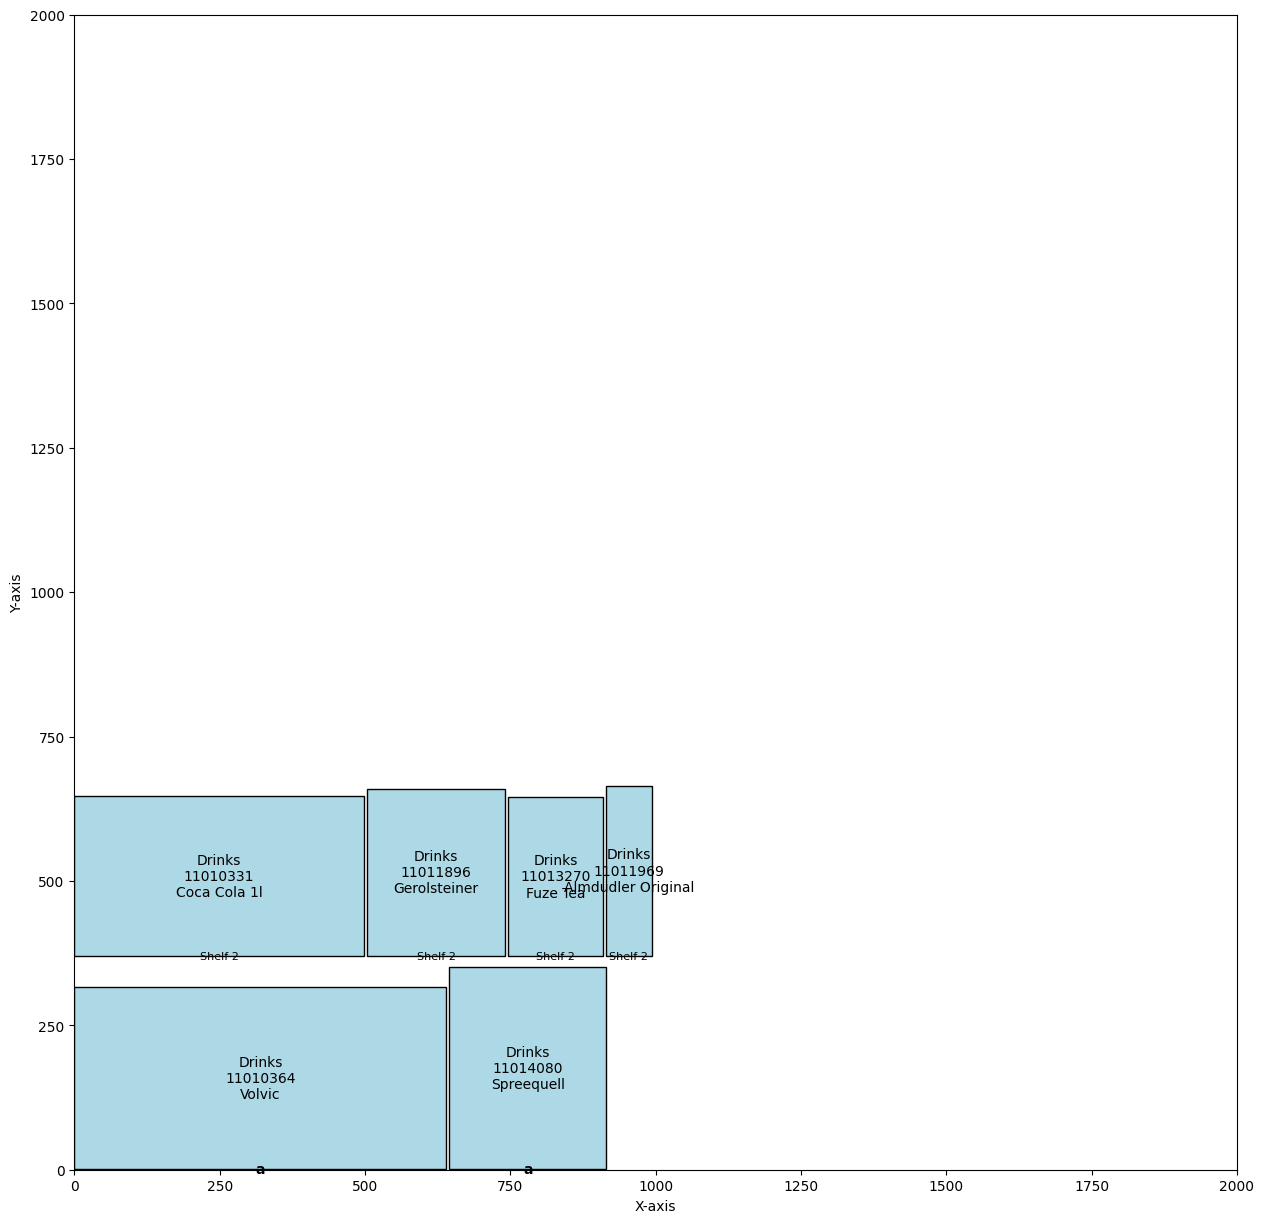

In [305]:
import matplotlib.pyplot as plt

# Define the planogram item coordinates and dimensions
item_data = [
    {'rack_id': 'a', 'shelf': 1, 'notation': 'Drinks\n11010364\nVolvic', 'x': 0, 'y': 1, 'width': 640, 'height': 315},
    {'rack_id': 'a', 'shelf': 1, 'notation': 'Drinks\n11014080\nSpreequell', 'x': 645, 'y': 1, 'width': 270, 'height': 350},
    {'rack_id': 'a', 'shelf': 2, 'notation': 'Drinks\n11010331\nCoca Cola 1l', 'x': 0, 'y': 370, 'width': 498, 'height': 277},
    {'rack_id': 'a', 'shelf': 2, 'notation': 'Drinks\n11011896\nGerolsteiner', 'x': 504, 'y': 370, 'width': 237, 'height': 290},
    {'rack_id': 'a', 'shelf': 2, 'notation': 'Drinks\n11013270\nFuze Tea', 'x': 746, 'y': 370, 'width': 163, 'height': 275},
    {'rack_id': 'a', 'shelf': 2, 'notation': 'Drinks\n11011969\nAlmdudler Original', 'x': 914, 'y': 370, 'width': 80, 'height': 295},
    # {'rack_id': 'a', 'shelf': 2, 'notation': 'Item 3', 'x': 0, 'y': 3, 'width': 3, 'height': 1.5},
    # {'rack_id': 'b', 'shelf': 1, 'notation': 'Item 4', 'x': 6, 'y': 1, 'width': 2, 'height': 2},
    # {'rack_id': 'b', 'shelf': 1, 'notation': 'Item 5', 'x': 8, 'y': 1, 'width': 2, 'height': 1.5},
]

# Create a new figure
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)

# Plot each planogram item as a rectangle
for item in item_data:
    rect = plt.Rectangle((item['x'], item['y']), item['width'], item['height'],
                         edgecolor='black', facecolor=colors[item['rack_id']])
    ax.add_patch(rect)
    ax.annotate(item['notation'], (item['x'] + 0.5 * item['width'], item['y'] + 0.5 * item['height']),
                color='black', ha='center', va='center')
    if item['shelf'] == 1:
      ax.text(item['x'] + 0.5 * item['width'], item['y'] - 0.5, item['rack_id'],
            color='black', ha='center', va='center', fontsize=10, fontweight='bold')
    else:
      ax.text(item['x'] + 0.5 * item['width'], item['y'] - 0.2, f"Shelf {item['shelf']}",
            color='black', ha='center', va='center', fontsize=8)

# Set the axis limits and labels
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot

plt.show()
